# Test Analyser

Read in the results data (from `data/results.csv` and analyse it. We use the [TAM](https://cran.r-project.org/web/packages/TAM/) package as it's capable of dealing with tests that have a mix of dichotomous and polytomous items. The goal here is to analyse a simulated test to ensure that it approximates a real world test.

We assume that the 1PL model is used.

$$
Pr(X=1) = \frac{exp(\theta-b)}{1 + exp(\theta-b)}
$$

We'll want to use the partial credit model (PCM) to analyse the data. Items are classed by the number of categories ($k$) that they contain; dichotomous items have a value of $k = 2, K = \{ 0, 1 \}$. The polytomous items have a varying number of categories.

I've found [chapter 4 of Introduction to Rasch Analysis in R](https://bookdown.org/dkatz/Rasch_Biome/polytomous-items.html) to be useful in understanding how to analyse polytomous tests using TAM.

## Data Ingest

For this analysis we need the `results.csv` file from the `data` folder.

In [4]:
library(tidyverse)
library(TAM)

dfRaw <- read_csv("data/results.csv")

dfTest <- dfRaw %>%
  dplyr::select(-systemname)

numItems <- ncol(dfTest)
numCandidates <- nrow(dfTest)


── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  systemname = col_character()
)
ℹ Use `spec()` for the full column specifications.




In [7]:
###### show a selection of data from the test...
head(dfRaw[c('systemname','A1L#01_7616', 'A1L#02_20679')])

systemname,A1L#01_7616,A1L#02_20679
<chr>,<dbl>,<dbl>
DT0001,1,1
DT0002,1,1
DT0003,1,1
DT0004,1,0
DT0005,1,1
DT0006,1,1


## Summary Stats
We'll use the TAM package to get some summary info for the dataset. TAM will automatically run the PCM when our data is polytomous. We need to remove the systemname (candidate ID) column first.

In [5]:
dfTestResponses <- dfRaw[-c(1)]

In [6]:
pcm <- tam(dfTestResponses)

....................................................
Processing Data      2022-05-04 22:13:08 
    * Response Data: 5000 Persons and  90 Items 
    * Numerical integration with 21 nodes
    * Created Design Matrices   ( 2022-05-04 22:13:08 )
    * Calculated Sufficient Statistics   ( 2022-05-04 22:13:09 )
....................................................
Iteration 1     2022-05-04 22:13:09
E Step
M Step Intercepts   |----
  Deviance = 274400.4629
  Maximum item intercept parameter change: 0.818552
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.936956
....................................................
Iteration 2     2022-05-04 22:13:09
E Step
M Step Intercepts   |----
  Deviance = 265227.8309 | Absolute change: 9172.632 | Relative change: 0.03458397
  Maximum item intercept parameter change: 0.313306
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance paramete

In [ ]:
summary(pcm)

## Item Difficulties
We can extract the item difficulties and use them to update the item bank if we wish.

In [8]:
dfItemUpdates <- pcm$item

In [9]:
head(dfItemUpdates[, c('item', 'N', 'M', 'xsi.item')])

,item,N,M,xsi.item
,<chr>,<dbl>,<dbl>,<dbl>
A1L#01_7616,A1L#01_7616,5000,0.8496,-2.6408977
A1L#02_20679,A1L#02_20679,5000,0.9238,-3.6698731
A1L#03_5480,A1L#03_5480,5000,0.5244,-0.1625308
A2L#04_5483,A2L#04_5483,5000,0.4342,0.4133995
A2L#05_24442,A2L#05_24442,5000,0.4204,0.5027913
A2L#06_7620,A2L#06_7620,5000,0.4300,0.4405421


Here, `N` is the number of responses, `M` is the ratio of correct responses and `xsi.item` is the item difficulty (or $b$ parameter).

In [10]:
# read in items.csv and create a joined dataset using the new
# item difficulties calculated from the test response analysis
dfItems <- read_csv("data/items.csv") %>%
  select(-c(b, se)) %>%
  left_join(dfItemUpdates, by = c("UIID" = "item")) %>%
  select(c(UIID, a, b = xsi.item, rating, k))

# then write out to a new items file
write_csv(dfItems, 'data/updated-items.csv')


── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  UIID = col_character(),
  a = col_double(),
  b = col_double(),
  se = col_double(),
  rating = col_character(),
  k = col_double()
)




### Polytomous Item Thresholds
Under the GRM or PCM polytomous IRT models, items are given a difficulty however, a set of thresholds $K$ is also required in order to fully describe the item. There must be $K-1$ thresholds (with threshold $k_0$ not being required to be supplied).

In [11]:
dfThresholds <- data.frame(tam.threshold(pcm))

In [12]:
(dfThresholds)

,Cat1
,<dbl>
A1L#01_7616,-2.6408386
A1L#02_20679,-3.6698914
A1L#03_5480,-0.1625061
A2L#04_5483,0.4133606
A2L#05_24442,0.5027161
A2L#06_7620,0.4404602
A2L#07_7627,0.5653381
B1L#08_20849,2.5963440
B1L#10_21135,3.1088562


In [13]:
write_csv(dfThresholds, 'data/item-thresholds.csv')

## Item Fit
We can calulcate the infit and outfit statistics. For polytomous items, the statistics are produced for each level.

In [14]:
Fit.poly <- tam.fit(pcm)

Item fit calculation based on 5 simulations
|**********|
|----------|


In [15]:
head(Fit.poly$itemfit)

,parameter,Outfit,Outfit_t,Outfit_p,Outfit_pholm,Infit,Infit_t,Infit_p,Infit_pholm
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A1L#01_7616,1.451716,14.2415369,5.060183e-46,4.098748e-44,0.9936648,-0.2229856,0.82354674,1
2,A1L#02_20679,4.500509,47.7670785,0.000000e+00,0.000000e+00,1.0142333,0.3612535,0.71790998,1
3,A1L#03_5480,1.052489,3.0338911,2.414216e-03,1.038113e-01,0.9910234,-0.5246487,0.59982743,1
4,A2L#04_5483,1.020758,1.1939347,2.325035e-01,1.000000e+00,0.9891928,-0.6242629,0.53245492,1
5,A2L#05_24442,0.980625,-1.1267611,2.598435e-01,1.000000e+00,0.9907807,-0.5276606,0.59773493,1
6,A2L#06_7620,1.011861,0.6829799,4.946196e-01,1.000000e+00,0.9716145,-1.6541520,0.09809662,1


## Item Information Functions
If we're interested we can get Item Characteristic Curves (ICCs) and Item Information Functions (IIFs) for the polytomous item thresholds. Here we'll show the ICCs and IIFs for items S1 (item 113) and W1 (item 123).

Iteration in WLE/MLE estimation  1   | Maximal change  1.3657 
Iteration in WLE/MLE estimation  2   | Maximal change  0.89 
Iteration in WLE/MLE estimation  3   | Maximal change  0.4713 
Iteration in WLE/MLE estimation  4   | Maximal change  0.0959 
Iteration in WLE/MLE estimation  5   | Maximal change  0.0023 
Iteration in WLE/MLE estimation  6   | Maximal change  2e-04 
Iteration in WLE/MLE estimation  7   | Maximal change  0 
----
 WLE Reliability= 0.957 


Warning message in max(tamobj$resp[, i], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


ERROR: Error in plot.window(...): need finite 'ylim' values


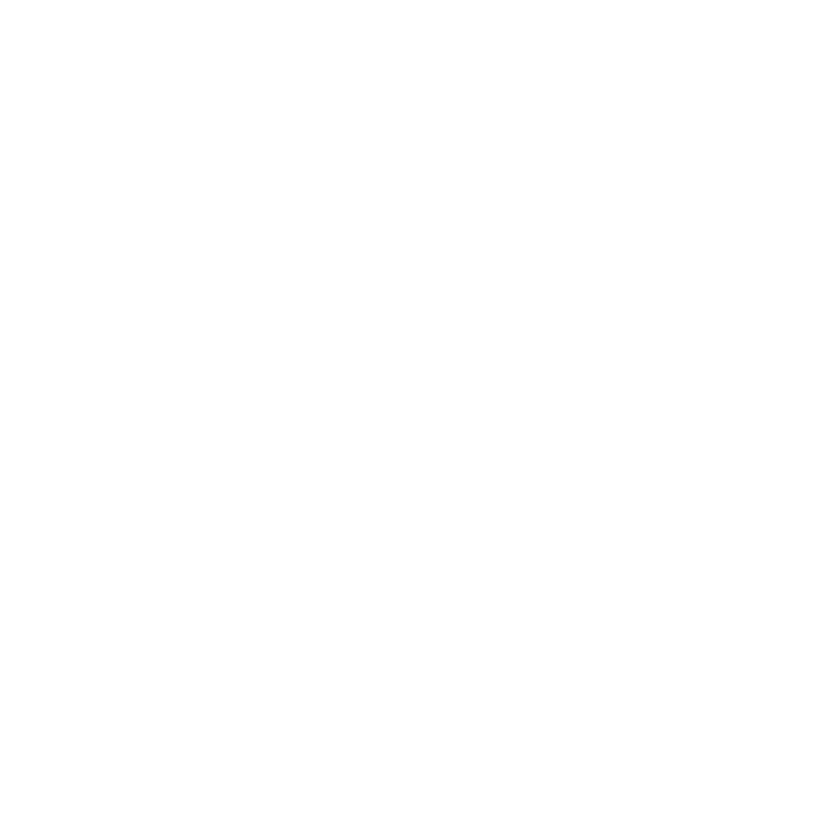

In [16]:
plot(pcm, items=113, type='expected', export=FALSE)

In [ ]:
plot(pcm, items=113, type='items', export=FALSE)

In [ ]:
plot(pcm, items=123, type='expected', export=FALSE)

In [ ]:
plot(pcm, items=123, type='items', export=FALSE)